# Italian error collection pipeline

 1. Filter the dataset words by non identified words
 2. Export erros to correction sheet
 3. Read the corrections sheet
 4. Combine all corrections
 5. Mark the dataset with the corrections
 6. Count the frequency of errors
 7. Export sheet to validation
 8. Classify the errors

In [4]:
import json
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt
import re
import string
import hunspell

In [5]:
it_spellchecker = hunspell.HunSpell('/home/rgomes/dictionaries/dictionaries/it/index.dic', '/home/rgomes/dictionaries/dictionaries/it/index.aff')

# Analyze the starting dataset
Initial analisis to identify the behavior of the dataset and words distribuition

In [6]:
def histogram(list):
    d={}
    for i in list:
        if i in d:
            d[i] += 1
        else:
            d[i] = 1
    return d

In [7]:
def histogramSorted(wordslist):
    h = histogram(wordslist)
    h = sorted(h.items(), key=lambda x: x[1], reverse=True)
    # remove the words that appears only once
    #h = filter(lambda x: x[1] > 1, h)
    return h

def plotHistogram(data):
    h = histogramSorted(data)
    h = map(lambda x: x[1], h)
    plt.plot(list(h))
    plt.show()

Total words from dataset: 1900669


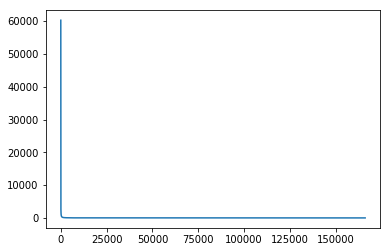

In [8]:
all_words = []
with open('../italian_words_all.txt', encoding='utf-8') as data_file_all:
    lines = data_file_all.readlines()
    all_words = list(map(lambda x: x.rstrip('\n').lower(), lines))
    all_words = list(map(lambda x: x.replace('!#$%&()*+,./:;<=>?@[\\]_{|}', ''), all_words))

print('Total words from dataset:', len(all_words))

plotHistogram(all_words)

# Working with the automatic suggestions list

In [9]:
def filterNonRecognizedWords(wordslist):
    a = map(lambda x: (x['word'], it_spellchecker.spell(x['word'])), wordslist)
    b = filter(lambda x: not x[1], a)
    return b

In [10]:
def filterRecognizedWords(wordslist):
    a = map(lambda x: (x['word'], it_spellchecker.spell(x['word'])), wordslist)
    b = filter(lambda x: x[1], a)
    return b

In [11]:
auto_spellchecker_data = []
with open('../auto.spellchecker.results.filtered.json', encoding='utf-8') as data_file_1:
    data = json.loads(data_file_1.read())
    auto_spellchecker_data = list(filter(lambda x: x,data))

# Filter the Hunspell non recognized words
auto_spellchecker_non_recognized = list(filterNonRecognizedWords(auto_spellchecker_data))

In [12]:
auto_spellchecker_non_recognized_accented = filter(lambda x: re.search(r'[À-ž\'\`]', x[0]),
                                                   auto_spellchecker_non_recognized)
# save on a file
# and the correct the words

In [13]:
corrected_ac_errors = []
with open('../italian_accented_erros.txt', encoding='utf-8') as data_file2:
    lines = data_file2.readlines()
    corrected_ac_errors = list(filter(lambda y: y != '',map(lambda x: x.rstrip('\n'), lines)))

In [14]:
corrected_words = []
for index,x in enumerate(auto_spellchecker_non_recognized_accented):
    if x[0] != corrected_ac_errors[index]:
        corrected_words.append((x[0], corrected_ac_errors[index]))
        
len(corrected_words)

114

## Read the csv with suggestions after correction

In [15]:
suggestions_csv = pd.read_csv('/home/rgomes/Downloads/suggestions filtered - suggestions.auto.csv')

# remove empty cells
suggestions_csv = suggestions_csv.replace(np.nan, '', regex=True)

# remove unused columns
suggestions_csv.drop(['is_italian_word', 'suggestions', 'HELPFUL LINK', 'Already removed words'], axis=1)

# load the csv corrections
suggestions_corrected = []
for _, row in suggestions_csv.iterrows():
    if row['spelling_correction']:
        suggestions_corrected.append((row['word'], row['spelling_correction']))
print('Total suggestions corrected:', len(suggestions_corrected))

Total suggestions corrected: 142


## Write the most common accented words not recognized by Hunspell

In [16]:
combined_corrections_map = list(set(corrected_words + suggestions_corrected))
print('Total corrections {}'.format(len(combined_corrections_map)))
combined_words_list = list(map(lambda x : x[0].lower(), combined_corrections_map))

h_all_words = histogram(all_words)
h_all_words_sorted = sorted(h_all_words.items(), key=lambda x: x[1], reverse=True)

a_ordered = filter(lambda x: re.search(r'[À-ž\'\`]', x[0]), h_all_words_sorted)
b_ordered = filter(lambda x: not it_spellchecker.spell(x[0]),a_ordered)
c_ordered = filter(lambda x: not(x[0] in combined_words_list),b_ordered)

accented_non_recognized = list(c_ordered)
count2 = 0
for w in accented_non_recognized:
    count2 = count2 + w[1]
print('Total accented words non recognized',count2)

# save to be corrected
with open('../ordered_last_errors.txt', 'w') as ordered_last_errors:
    for item in accented_non_recognized:
        print(item[0])
        ordered_last_errors.write(item[0] + '\n')
        
        

Total corrections 252
Total accented words non recognized 21459
e'
c’è
é
pò
piu'
città,
l'
citta'
però,
più,
c'e'
perche'
così,
all'
gia'
lì,
sì,
dell'
c'e
puo'
nè
'
perché,
(è
cosi'
dall'italia
caffè,
e`
piú
dall'
pero'
d'
è,
musée
sara'
citta',
un'
po',
dell'isola,
città!
plaça
realtà,
più!
(più
là,
li'
xchè
thè
sull'
libertà,
l'auto,
fà
citta'.
caffe'
città:
anch'io,
lunedì,
ne'
niccolò
sè
curiosità:
già,
à
curiosità,
dall'italia,
d'acqua,
cio'
l'altro,
dell'hotel,
all'aperto,
l'italia
così:
vabbè,
verità,
perchè,
all'hotel,
l'audioguida
(già
l'hotel,
',
tranquillità,
venerdì,
cosi`
fa'
un'ora,
metà,
più?
è:
possibilita'
regent's
com’è
nell'
difficoltà,
età,
attività,
d'europa
và
gesù
(perché
città?
dall'italia.
città)
all'interno,
l'africa
'.
mezz'ora,
piu`
meta'
ahimè,
c'
all'albergo,
king's
d'ingresso,
perche`
un'altro
perù
è'
all'esterno,
qualità,
giovedì,
earl's
piu',
anch'io!
corfù
realta'
sull'isola,
all'aeroporto,
(così
l'aeroporto,
giu'
l'altra,
l'itinerario,
all'ingresso,


seguito...l'inizio
l'ibiza
dell'adriatico)
natìa.
descriverò:
moltó,
dell'aubrac
(aimé...)
(ri-aimé)
all'unisono...poi
(cioè...vediamo
è....un
passé?
l'avez
dépoulpé"
auray...vedrò
scendendo...l'atmosfera
l'accompagnatore)
l'accompagnatore,
all'isoladal
n'tichka
all'auto,
dell'ounila,
l'oasi,
dadès,
dadès.
un'australia
lá,
proprietá
approdó
moltó.
sott'olio.
dell'azienda,
salato...è
soddisferà,
nazionalitá
cittá,
confessó
macquarie's
inglesi.é
permetterá
unicitá
basterá
l'echo
trasformó
morí
mezz'oretta)
dell'australia,
dell'australia?"
l'australia"
"polały
się
rzęsiste,
dzieciństwo
moją
młodość
górna
durną,
mój
męski,
klęski.
polały
rzęsiste."adam
l'ulica
główny
l'ermellino"...
un'ora.in
(l'orario
vestibolo.all'entrata
lanckoroński.
ravensbrück,
l'ermellino"
l'ammira,
l'ora.:-)dopo
dżok,
dżok
bronisław
d'oro...)
agosto:e'
anticipo.l'allestimento
podgórze,
bohaterów
dell'aquila,
dà,
płaszów,
lutto.e'
dell'arsenale,
kuźnice
lassù...dopo
częstochowa
marché
provençal
http://www.antibesjua

ballaro'
(dall'arabo
all'alizar.
l'alizar
l'ora"???
un'aggeggio
dall'alizar,
(l'oceano)si
speciale......l'odore
mattina,e'un
rabaçal
'madeira'
'madeira
walks'
mountuosità
'palafitte'
c'eran
città...se
d'amore...appena
un'idea,
l'illuminazione:
l'ora!"
normalita',
s'interrompe,
bell'aiuto,
l'agora',
cambiera'
all'orologio,
servitu'
cliche'
l'ortigia.
l'aggravante,
l'elefantino,
nell'omerta'
vìa
cìrculo
serra.tripadvisor.it/attraction_review-g-d…all'uscita
l'anniversario!!!!!
'sul
sicuro'.
tappe....pero'
all'altro:
ma'in,
gesù).
di...più
all'uscita;
l'etna
dell'etna.
l'etna,
dall'europa,
realta'.
negativita'
riferito,è
all'aperto,con
curati,bambù
d'italia",ossia
l'orologio:
d'insieme:
po'quelli
dell'attentato:
dell'accaduto:
bell'effetto,
imerovigli.l'isola
qualita',
perissa...e'
qualita'romanticismo
la'cqua
un'atmosfera,
coppia,perchè
l'altro,ci
perchè,per
un'isoletta,di
d'atterraggio,senza
l'altro....ora
attrezzata,c'è
(l'
nell'.
benvenute.quest'anno
ma,ne'
volta.l'aeroporto
meta'delle

all''hotel
cèspedes
l'habana
dell'habana
“difficoltà”
entrè),
lì…
l'incitamento,
viaggio.l'occasione
all'australia.mi
[continuerò
sfottò
despereès”
l'ora!!!!!abbi
lutèce,
saint-germain-des-prés,
all'arènes
lutèce
saint-germain-des-prés
sacré-coeur,
bienvenüe.
sacré-coeur
dèfense,
dèfense.
lumenn'
…imageshack.us/img//pi.jpgall'aeroporto
quest'uomo,
dev'esser
mercoled'
élysées,
(menù
dell'immacolata)
imageshack.us/photo/my-images//noiy.jpg/così
fà!"
sull'oronte
all'arizona
dell'arizona.
dell'arizona"
lì????
un'altre
mondo.l'unico
dall'eroporto
dell'accoppiamento,
dell'hotel,cibo
amicizie,quest'anno
sò,ma
dell'airberlin,
infranserò
all'a
*ç*.
età".
;)all'eroporto
*ç*,
prossima.trascorrerò
(riuscirò
all'originale)puoi
dire...è
watercolors..(.lì
dell'egitto
verità”
lì…).
età!!!!!!!!!!!!!
mercè....
hoolalà
(l'atollo
divertirvi.attivita':
libertà!!come
(tè)
però…)
vedanthangal.è
namastè!!!!!
kenya.giovedì
dall'italia!
e'avventuroso
e'cosa
vedono...è
parcheggio..........l'albergo
l'aiuto,
l'at

## Load the most common accented words corrections

In [17]:
last_corrections = []
with open('../ordered_last_errors_corrected.txt') as ordered_last_corrections:
    lines = list(map(lambda x: x.rstrip('\n').lower(), ordered_last_corrections))
    for index, item in enumerate(accented_non_recognized):
        if item[0] != lines[index]:
            last_corrections.append((item[0],lines[index]))
print(len(last_corrections))

92


## Group all corrections realized

In [18]:
combined_corrections_map = list(set(corrected_words + suggestions_corrected + last_corrections))
print('Total corrections {}'.format(len(combined_corrections_map)))

combined_words_list = list(map(lambda x : x[0].lower(), combined_corrections_map))
mapped_combined_words = list(filter(lambda x : x[0].lower() in combined_words_list, h_all_words_sorted))

#remove rare cases and outliers
# todo: remove nonsense words verified by norton
total_words = list(filter(lambda x: x,mapped_combined_words))

count = 0
for w in total_words:
    count = count + w[1]

print('Total corrections with repetition {}'.format(count))

Total corrections 344
Total corrections with repetition 6872


## Export the corrections to verification and statistical analysis

In [19]:
all_count_dict = dict((a[0], a) for a in total_words)
all_corrections_dict = dict((a[0], a) for a in combined_corrections_map)

all_data = []
for item in all_count_dict:
    if all_corrections_dict.get(item):
        all_data.append((item, all_count_dict[item][1], all_corrections_dict[item][1]))

print(len(all_data))
df = pd.DataFrame(all_data)
df.to_csv('../final_corrections.csv')

235


In [20]:
with open('../errors_final_list.txt', 'w') as errors_list_file:
    for word in (list(df[0].values)):
        errors_list_file.write(word + '\n')

In [21]:
# make sure that all the corrections are counted, removing punctuations
print(len(set(all_words)))
# use the native python punctuation list but remove accents related like "'^`~
#print(string.punctuation)
all_words_no_punctuation = list(map(lambda x: x.rstrip('!#$%&()*+,-./:;<=>?@[\\]_{|}') ,all_words))
print(len(set(all_words_no_punctuation)))

# save to be validated and check more errors on LibreOffice
with open('../ordered_all_words_no_punctuation.txt', 'w') as file_all_1:
    for w in all_words_no_punctuation:
        file_all_1.write(w + '\n')

166011
110965


In [24]:
combined_words_list_final = list(map(lambda x : x[0].lower(), asdfgh))
mapped_combined_words_final = list(filter(lambda x : x[0].lower() in combined_words_list_final, h_all_words_sorted))

count_total = 0
for w in mapped_combined_words_final:
    count_total = count_total + w[1]

print('FINAL Total corrections with repetition {}'.format(count_total))

NameError: name 'asdfgh' is not defined

In [25]:
all_count_dict_final = dict((a[0], a) for a in mapped_combined_words_final)
all_corrections_dict_final = dict((a[0], a) for a in asdfgh)
all_data_final = []
for item in all_count_dict_final:
    if all_corrections_dict_final.get(item):
        all_data_final.append((item, all_count_dict_final[item][1], all_corrections_dict_final[item][1]))

print(len(all_data_final))
df = pd.DataFrame(all_data_final)
df.to_csv('../final_corrections2.csv')

NameError: name 'mapped_combined_words_final' is not defined

In [26]:
corrected_words + suggestions_corrected + last_corrections
last_corrections

[("e'", "\ufeffe'"),
 ('pò', 'po’'),
 ("piu'", 'più'),
 ("citta'", 'città'),
 ("c'e'", "c'è"),
 ("perche'", 'perché'),
 ("gia'", 'già'),
 ("c'e", "c'è"),
 ("puo'", 'può'),
 ('piú', 'più'),
 ("pero'", 'però'),
 ("sara'", 'sarà'),
 ("citta',", 'città,'),
 ('thè', 'tè'),
 ("citta'.", 'città.'),
 ("caffe'", 'caffè'),
 ("ne'", 'né'),
 ("cio'", "ciò'"),
 ('perchè,', 'perché,'),
 ("possibilita'", "possibilità'"),
 ('piu`', 'più'),
 ('perche`', 'perché'),
 ("piu',", 'più,'),
 ("realta'", 'realtà'),
 ("giu'", 'giù'),
 ('cafè,', 'caffè,'),
 ("localita'", 'località'),
 ('granchè,', 'granché,'),
 ('c’e`', 'c’è'),
 ("chissa'", 'chissà'),
 ("cioe'", 'cioè'),
 ('cafè.', 'caffè.'),
 ("finche'", 'finché'),
 ('perchè.', 'perché.'),
 ("difficolta'", 'difficoltà'),
 ("disponibilita'", 'disponibilità'),
 ("tornero'", 'tornerò'),
 ('affinchè', 'affinché'),
 ("venerdi'", 'venerdì'),
 ('ahimé', 'ahimè'),
 ("piu'.", 'più.'),
 ('(perchè', '(perché'),
 ('giá', 'già'),
 ("giovedi'", 'giovedì'),
 ("dall'areoporto"

In [27]:
with open('../italian_posts.txt') as italian_posts:
    it_posts = italian_posts.read()

In [28]:
len(it_posts)

12819150

In [29]:
df_corrections = pd.read_csv('/home/rgomes/Downloads/Correções Italiano - Correções.csv')
df_corrections

,Palavra com erro,Correção,Ocorrências,Categoria de Erro 1,Categoria de Erro 2,Categoria de Erro 3
0,e',è,2201,Acento Errado,NaN,NaN
1,perchè,perché,1237,Acento Errado,NaN,NaN
2,pò,po’,568,Acento Errado,NaN,NaN
3,piu',più,548,Acento Errado,NaN,NaN
4,citta',città,180,Acento Errado,NaN,NaN
5,c'e',c'è,145,Acento Errado,NaN,NaN
6,perche',perché,144,Acento Errado,NaN,NaN
7,gia',già,124,Acento Errado,NaN,NaN
8,c'e,c'è,99,Acento Errado,NaN,NaN
9,puo',può,97,Acento Errado,NaN,NaN


In [30]:
import shutil
shutil.copyfile('../italian_posts.txt', '../italian_posts_marked.txt')    

'../italian_posts_marked.txt'

In [31]:
for w in df_corrections["Palavra com erro"].values:
    marked_file_read = open('../italian_posts_marked.txt')
    regex = re.compile(r'\s{}\s'.format(w), re.IGNORECASE)
    print(regex)
    marked_string = re.sub(regex, " {{ # }} ".replace('#', w),marked_file_read.read())

    marked_file_write = open('../italian_posts_marked.txt', 'w')
    marked_file_write.write(marked_string)

re.compile("\\se'\\s", re.IGNORECASE)
re.compile('\\sperchè\\s', re.IGNORECASE)
re.compile('\\spò\\s', re.IGNORECASE)
re.compile("\\spiu'\\s", re.IGNORECASE)
re.compile("\\scitta'\\s", re.IGNORECASE)
re.compile("\\sc'e'\\s", re.IGNORECASE)
re.compile("\\sperche'\\s", re.IGNORECASE)
re.compile("\\sgia'\\s", re.IGNORECASE)
re.compile("\\sc'e\\s", re.IGNORECASE)
re.compile("\\spuo'\\s", re.IGNORECASE)
re.compile('\\scafè\\s', re.IGNORECASE)
re.compile('\\spiú\\s', re.IGNORECASE)
re.compile('\\spoichè\\s', re.IGNORECASE)
re.compile("\\spero'\\s", re.IGNORECASE)
re.compile('\\sfinchè\\s', re.IGNORECASE)
re.compile("\\ssara'\\s", re.IGNORECASE)
re.compile("\\sc'é\\s", re.IGNORECASE)
re.compile('\\saereoporto\\s', re.IGNORECASE)
re.compile('\\sdopodichè\\s', re.IGNORECASE)
re.compile('\\scittá\\s', re.IGNORECASE)
re.compile('\\sthè\\s', re.IGNORECASE)
re.compile('\\squì\\s', re.IGNORECASE)
re.compile("\\scaffe'\\s", re.IGNORECASE)
re.compile("\\sne'\\s", re.IGNORECASE)
re.compile("\\scio'\\s"

re.compile('\\saereomobili\\s', re.IGNORECASE)
re.compile('\\saccettavan\\s', re.IGNORECASE)
re.compile('\\saihmè\\s', re.IGNORECASE)
re.compile('\\sadattore\\s', re.IGNORECASE)
re.compile('\\sfuorchè\\s', re.IGNORECASE)
re.compile('\\sbenissmo\\s', re.IGNORECASE)
re.compile('\\scaffèlatte\\s', re.IGNORECASE)
re.compile('\\smangierò\\s', re.IGNORECASE)
re.compile('\\scittàda\\s', re.IGNORECASE)
re.compile('\\savevao\\s', re.IGNORECASE)
re.compile('\\sbenearrivata\\s', re.IGNORECASE)
re.compile('\\saffittao\\s', re.IGNORECASE)
re.compile('\\stessò\\s', re.IGNORECASE)
re.compile('\\sarcheoculturale\\s', re.IGNORECASE)
re.compile('\\safffluenza\\s', re.IGNORECASE)
re.compile("\\sperche'chi\\s", re.IGNORECASE)
re.compile('\\sneanchè\\s', re.IGNORECASE)
re.compile('\\saccomapagnava\\s', re.IGNORECASE)
re.compile('\\sansisssiiiima\\s', re.IGNORECASE)
re.compile('\\sarchitettonco\\s', re.IGNORECASE)
re.compile('\\sasssoluto\\s', re.IGNORECASE)
re.compile('\\sascoltarloi\\s', re.IGNORECASE)
re